In [ ]:
# ==================== IMPORT LIBRARIES ====================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from sklearn.model_selection import (train_test_split, cross_val_score,
                                     StratifiedKFold, GridSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, auc)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [ ]:
# ==================== LOAD & EXPLORE DATA ====================
df = pd.read_csv("mental_health_remote_workers.csv")

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nDuplicates: {df.duplicated().sum()}")

# Display sample
print("\n" + "="*70)
print("SAMPLE DATA (First 5 rows)")
print("="*70)
df.head()

DATASET OVERVIEW
Shape: (100, 20)

Columns: ['Employee_ID', 'Name', 'Age', 'Gender', 'Country', 'Job_Role', 'Experience_Years', 'Work_Mode', 'Hours_Worked_Per_Week', 'Productivity_Score', 'Mental_Health_Status', 'Burnout_Score', 'Sleep_Hours_Per_Day', 'Exercise_Frequency', 'Work_Life_Balance_Rating', 'Has_Access_To_Therapist', 'Willing_To_Return_Onsite', 'Remote_Setup_Satisfaction', 'Internet_Issues_Frequency', 'Team_Communication_Effectiveness']

Data Types:
Employee_ID                           int64
Name                                 object
Age                                   int64
Gender                               object
Country                              object
Job_Role                             object
Experience_Years                    float64
Work_Mode                            object
Hours_Worked_Per_Week               float64
Productivity_Score                  float64
Mental_Health_Status                 object
Burnout_Score                         int64
Sleep_Ho

,Employee_ID,Name,Age,Gender,Country,Job_Role,Experience_Years,Work_Mode,Hours_Worked_Per_Week,Productivity_Score,Mental_Health_Status,Burnout_Score,Sleep_Hours_Per_Day,Exercise_Frequency,Work_Life_Balance_Rating,Has_Access_To_Therapist,Willing_To_Return_Onsite,Remote_Setup_Satisfaction,Internet_Issues_Frequency,Team_Communication_Effectiveness
0,1,User_1,28,Female,Canada,QA Engineer,5.4,Onsite,45.4,6.6,Poor,44,5.7,Rarely,7.5,True,False,9.9,Sometimes,7.7
1,2,User_2,41,Prefer not to say,Australia,DevOps Engineer,10.5,Remote,40.4,8.4,Good,58,5.1,Daily,8.6,False,True,2.5,Often,9.0
2,3,User_3,36,Male,Germany,UI/UX Designer,11.9,Hybrid,43.6,6.6,Good,78,6.1,Never,6.2,False,False,9.1,Often,7.7
3,4,User_4,32,Prefer not to say,Germany,Product Manager,15.6,Hybrid,41.3,9.0,Moderate,71,5.4,Rarely,8.5,True,True,6.1,Sometimes,8.4
4,5,User_5,29,Male,UK,DevOps Engineer,1.8,Hybrid,42.5,6.9,Poor,69,7.1,Never,6.0,True,True,9.3,Never,4.7


In [ ]:
# ==================== EXPLORATORY DATA ANALYSIS ====================

# Target variable distribution
print("\n" + "="*70)
print("TARGET VARIABLE ANALYSIS")
print("="*70)
print(f"\nWilling to Return Onsite Distribution:")
print(df['Willing_To_Return_Onsite'].value_counts())
print(f"\nPercentage:")
print(df['Willing_To_Return_Onsite'].value_counts(normalize=True) * 100)

# Visualize target distribution
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Target Distribution', 'Mental Health Status'))

fig.add_trace(
    go.Bar(x=['Not Willing', 'Willing'],
           y=df['Willing_To_Return_Onsite'].value_counts().values,
           marker_color=['#FF6B6B', '#4ECDC4'],
           text=df['Willing_To_Return_Onsite'].value_counts().values,
           textposition='auto'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df['Mental_Health_Status'].value_counts().index,
           y=df['Mental_Health_Status'].value_counts().values,
           marker_color=['#95E1D3', '#F38181', '#AA96DA'],
           text=df['Mental_Health_Status'].value_counts().values,
           textposition='auto'),
    row=1, col=2
)

fig.update_layout(height=400, showlegend=False, title_text="Key Variables Distribution")
fig.show()


TARGET VARIABLE ANALYSIS

Willing to Return Onsite Distribution:
Willing_To_Return_Onsite
True     54
False    46
Name: count, dtype: int64

Percentage:
Willing_To_Return_Onsite
True     54.0
False    46.0
Name: proportion, dtype: float64


In [ ]:
# Correlation with target
fig = px.box(df, x='Willing_To_Return_Onsite', y='Burnout_Score',
             title='Burnout Score vs Willingness to Return Onsite',
             color='Willing_To_Return_Onsite',
             labels={'Willing_To_Return_Onsite': 'Willing to Return'})
fig.show()

fig = px.box(df, x='Willing_To_Return_Onsite', y='Work_Life_Balance_Rating',
             title='Work-Life Balance vs Willingness to Return Onsite',
             color='Willing_To_Return_Onsite')
fig.show()

# Mental Health Status distribution
fig = px.histogram(df, x='Mental_Health_Status', color='Willing_To_Return_Onsite',
                   title='Mental Health Status by Return Willingness',
                   barmode='group')
fig.show()

In [ ]:
# ==================== ENHANCED DATA PREPROCESSING ====================

# Create a copy for preprocessing
df_processed = df.copy()

# Drop unnecessary columns
df_processed.drop(columns=['Employee_ID', 'Name'], inplace=True)

print("\n" + "="*70)
print("ENHANCED DATA PREPROCESSING")
print("="*70)

# Encode Mental Health Status (ordinal encoding)
mental_health_mapping = {'Poor': 0, 'Moderate': 1, 'Good': 2}
df_processed['Mental_Health_Status'] = df_processed['Mental_Health_Status'].map(mental_health_mapping)

# Encode Exercise Frequency (ordinal)
exercise_mapping = {'Never': 0, 'Rarely': 1, '2-3x/Week': 2, 'Daily': 3}
df_processed['Exercise_Frequency'] = df_processed['Exercise_Frequency'].map(exercise_mapping)

# Encode Internet Issues Frequency (ordinal)
internet_mapping = {'Never': 0, 'Sometimes': 1, 'Often': 2}
df_processed['Internet_Issues_Frequency'] = df_processed['Internet_Issues_Frequency'].map(internet_mapping)

# ENHANCEMENT: Create interaction features
df_processed['Mental_Health_x_Burnout'] = df_processed['Mental_Health_Status'] * df_processed['Burnout_Score']
df_processed['Exercise_x_Mental_Health'] = df_processed['Exercise_Frequency'] * df_processed['Mental_Health_Status']
df_processed['WorkLife_x_Mental_Health'] = df_processed['Work_Life_Balance_Rating'] * df_processed['Mental_Health_Status']
df_processed['Stress_x_Burnout'] = df_processed['Stress_Level'] * df_processed['Burnout_Score']

# ENHANCEMENT: Create binned features for continuous variables
df_processed['Burnout_Score_Binned'] = pd.cut(df_processed['Burnout_Score'], 
                                             bins=[0, 3, 6, 8, 10], 
                                             labels=[0, 1, 2, 3])
df_processed['Stress_Level_Binned'] = pd.cut(df_processed['Stress_Level'], 
                                            bins=[0, 3, 6, 8, 10], 
                                            labels=[0, 1, 2, 3])
df_processed['WorkLife_Binned'] = pd.cut(df_processed['Work_Life_Balance_Rating'], 
                                        bins=[0, 2, 4, 6, 8, 10], 
                                        labels=[0, 1, 2, 3, 4])

# Convert binned features to numeric
df_processed['Burnout_Score_Binned'] = df_processed['Burnout_Score_Binned'].astype(int)
df_processed['Stress_Level_Binned'] = df_processed['Stress_Level_Binned'].astype(int)
df_processed['WorkLife_Binned'] = df_processed['WorkLife_Binned'].astype(int)

# One-hot encoding for nominal categorical variables
nominal_cols = ['Gender', 'Country', 'Job_Role', 'Work_Mode']
df_processed = pd.get_dummies(df_processed, columns=nominal_cols, drop_first=True)

# Convert boolean to int
bool_cols = ['Has_Access_To_Therapist', 'Willing_To_Return_Onsite']
for col in bool_cols:
    df_processed[col] = df_processed[col].astype(int)

print(f"Enhanced processed shape: {df_processed.shape}")
print(f"Features (including engineered): {df_processed.shape[1] - 1}")
print("\nNew engineered features:")
print("- Mental_Health_x_Burnout")
print("- Exercise_x_Mental_Health") 
print("- WorkLife_x_Mental_Health")
print("- Stress_x_Burnout")
print("- Burnout_Score_Binned")
print("- Stress_Level_Binned")
print("- WorkLife_Binned")
df_processed.head()


DATA PREPROCESSING
Processed shape: (100, 30)
Features: 29


,Age,Experience_Years,Hours_Worked_Per_Week,Productivity_Score,Mental_Health_Status,Burnout_Score,Sleep_Hours_Per_Day,Exercise_Frequency,Work_Life_Balance_Rating,Has_Access_To_Therapist,...,Country_India,Country_UK,Country_USA,Job_Role_DevOps Engineer,Job_Role_Developer,Job_Role_Product Manager,Job_Role_QA Engineer,Job_Role_UI/UX Designer,Work_Mode_Onsite,Work_Mode_Remote
0,28,5.4,45.4,6.6,0,44,5.7,1,7.5,1,...,False,False,False,False,False,False,True,False,True,False
1,41,10.5,40.4,8.4,2,58,5.1,3,8.6,0,...,False,False,False,True,False,False,False,False,False,True
2,36,11.9,43.6,6.6,2,78,6.1,0,6.2,0,...,False,False,False,False,False,False,False,True,False,False
3,32,15.6,41.3,9.0,1,71,5.4,1,8.5,1,...,False,False,False,False,False,True,False,False,False,False
4,29,1.8,42.5,6.9,0,69,7.1,0,6.0,1,...,False,True,False,True,False,False,False,False,False,False


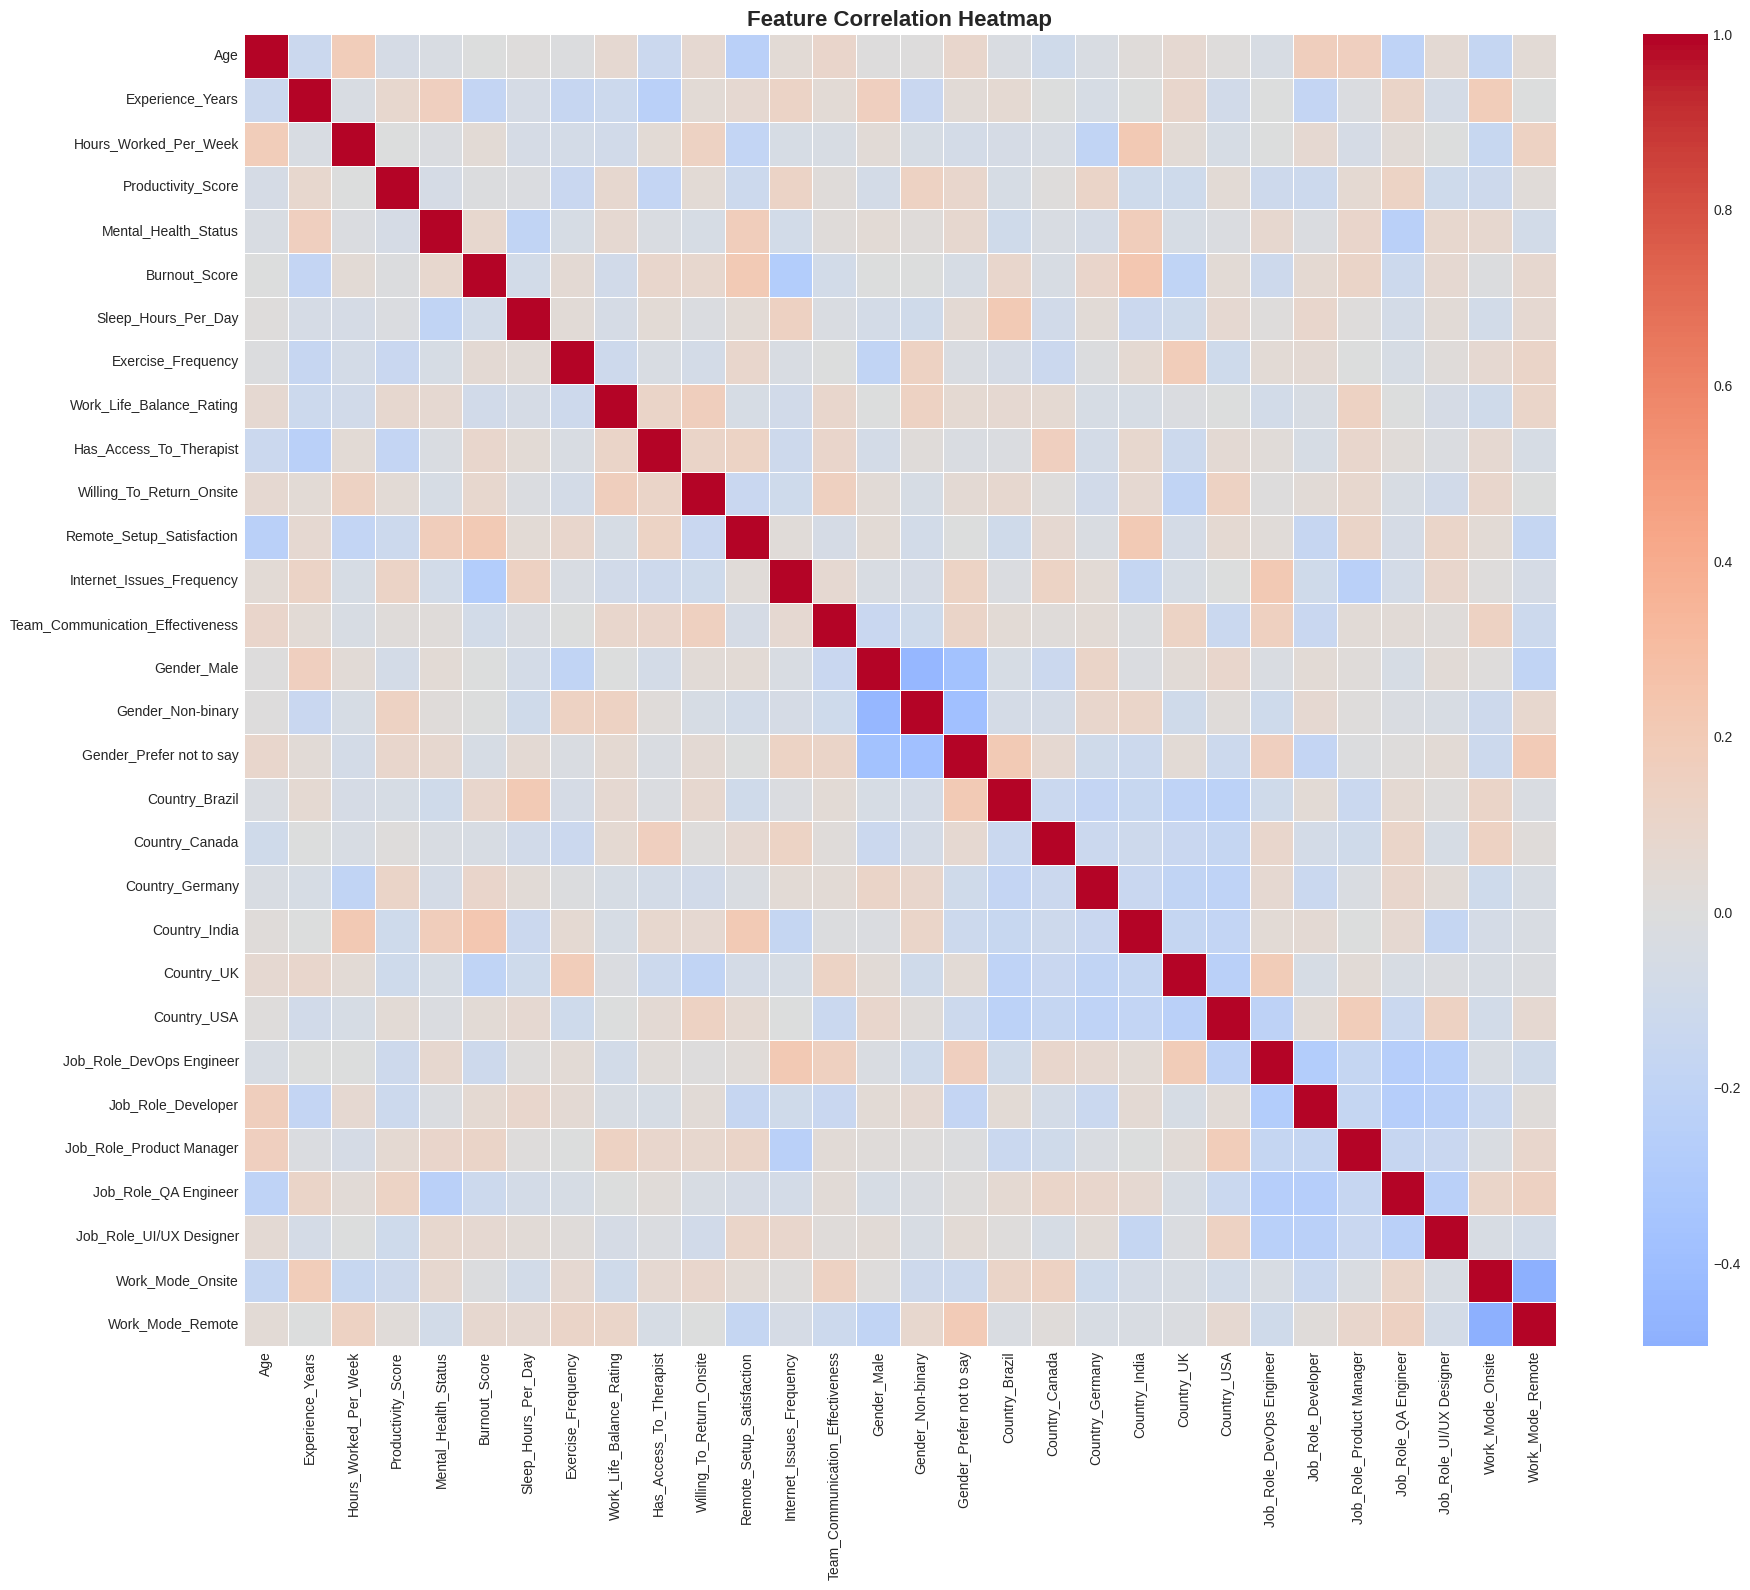


FEATURES CORRELATION WITH TARGET
Willing_To_Return_Onsite            1.000000
Work_Life_Balance_Rating            0.166985
Team_Communication_Effectiveness    0.150862
Hours_Worked_Per_Week               0.140495
Country_USA                         0.131034
Has_Access_To_Therapist             0.117269
Work_Mode_Onsite                    0.089656
Burnout_Score                       0.082689
Job_Role_Product Manager            0.079926
Country_Brazil                      0.074433
Country_India                       0.067973
Age                                 0.067086
Gender_Prefer not to say            0.048859
Productivity_Score                  0.043127
Experience_Years                    0.037993
Gender_Male                         0.035027
Job_Role_Developer                  0.032512
Country_Canada                      0.009815
Job_Role_DevOps Engineer            0.005812
Work_Mode_Remote                   -0.005711
Sleep_Hours_Per_Day                -0.017123
Job_Role_QA Engineer 

In [ ]:
# ==================== FEATURE CORRELATION ANALYSIS ====================

# Calculate correlation matrix
correlation_matrix = df_processed.corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlation with target
target_correlation = correlation_matrix['Willing_To_Return_Onsite'].sort_values(ascending=False)
print("\n" + "="*70)
print("FEATURES CORRELATION WITH TARGET")
print("="*70)
print(target_correlation)

# Visualize top correlations
top_features = target_correlation.head(11)[1:]  # Exclude target itself
fig = px.bar(x=top_features.values, y=top_features.index, orientation='h',
             title='Top 10 Features Correlated with Target',
             labels={'x': 'Correlation', 'y': 'Feature'},
             color=top_features.values,
             color_continuous_scale='RdYlGn')
fig.show()

In [ ]:
# ==================== ENHANCED FEATURE SELECTION & SCALING ====================

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier

X = df_processed.drop(columns=['Willing_To_Return_Onsite'])
y = df_processed['Willing_To_Return_Onsite']

print("\n" + "="*70)
print("ENHANCED FEATURE SELECTION")
print("="*70)

# Feature selection using multiple methods
# 1. Mutual Information
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_scores = mi_selector.fit(X, y).scores_

# 2. F-test
f_selector = SelectKBest(score_func=f_classif, k='all')
f_scores = f_selector.fit(X, y).scores_

# 3. Tree-based feature importance
tree_selector = ExtraTreesClassifier(n_estimators=100, random_state=42)
tree_selector.fit(X, y)
tree_scores = tree_selector.feature_importances_

# Combine scores (normalize and average)
from sklearn.preprocessing import MinMaxScaler
score_scaler = MinMaxScaler()

mi_scores_norm = score_scaler.fit_transform(mi_scores.reshape(-1, 1)).flatten()
f_scores_norm = score_scaler.fit_transform(f_scores.reshape(-1, 1)).flatten()
tree_scores_norm = score_scaler.fit_transform(tree_scores.reshape(-1, 1)).flatten()

# Combined feature importance
combined_scores = (mi_scores_norm + f_scores_norm + tree_scores_norm) / 3

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores_norm,
    'F_Score': f_scores_norm,
    'Tree_Score': tree_scores_norm,
    'Combined_Score': combined_scores
}).sort_values('Combined_Score', ascending=False)

print("Top 15 features by combined importance:")
print(feature_importance_df.head(15)[['Feature', 'Combined_Score']].to_string(index=False))

# Select top features (keep at least 15 features for small dataset)
n_features = min(20, len(X.columns))
top_features = feature_importance_df.head(n_features)['Feature'].tolist()
X_selected = X[top_features]

print(f"\nSelected {len(top_features)} features for modeling")

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.25, random_state=42, stratify=y
)

print("\n" + "="*70)
print("DATA SPLIT WITH SELECTED FEATURES")
print("="*70)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining set class distribution:\n{y_train.value_counts()}")
print(f"\nTest set class distribution:\n{y_test.value_counts()}")

# Enhanced scaling - try both StandardScaler and MinMaxScaler
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

X_train_scaled_std = scaler_standard.fit_transform(X_train)
X_test_scaled_std = scaler_standard.transform(X_test)

X_train_scaled_mm = scaler_minmax.fit_transform(X_train)
X_test_scaled_mm = scaler_minmax.transform(X_test)

print("\nFeatures scaled using both StandardScaler and MinMaxScaler ✓")


DATA SPLIT
Training set: (75, 29)
Test set: (25, 29)

Training set class distribution:
Willing_To_Return_Onsite
1    41
0    34
Name: count, dtype: int64

Test set class distribution:
Willing_To_Return_Onsite
1    13
0    12
Name: count, dtype: int64

Features scaled using StandardScaler ✓


In [ ]:
# ==================== ENHANCED MODEL TRAINING & EVALUATION ====================

from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.model_selection import cross_validate

# Enhanced models with better hyperparameters
models_std = {
    "Logistic Regression": LogisticRegression(max_iter=3000, random_state=42, C=1.0, solver='liblinear'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, weights='distance'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=6, min_samples_split=8, min_samples_leaf=4),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, max_depth=8, 
                                          min_samples_split=8, min_samples_leaf=4, max_features='sqrt'),
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, random_state=42, max_depth=8,
                                       min_samples_split=8, min_samples_leaf=4),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42, max_depth=4, 
                                                   learning_rate=0.05, subsample=0.8),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42, learning_rate=0.8),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=42, C=2.0, gamma='scale'),
    "SVM (Linear)": SVC(kernel='linear', probability=True, random_state=42, C=1.0),
    "Naive Bayes": GaussianNB(var_smoothing=1e-9),
    "XGBoost": XGBClassifier(n_estimators=200, random_state=42, max_depth=4, learning_rate=0.05, 
                            subsample=0.8, colsample_bytree=0.8, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=200, random_state=42, max_depth=4, learning_rate=0.05,
                              subsample=0.8, colsample_bytree=0.8, verbose=-1)
}

# Models for MinMax scaling
models_mm = {
    "Logistic Regression MM": LogisticRegression(max_iter=3000, random_state=42, C=1.0, solver='liblinear'),
    "K-Nearest Neighbors MM": KNeighborsClassifier(n_neighbors=5, weights='distance'),
    "SVM (RBF) MM": SVC(kernel='rbf', probability=True, random_state=42, C=2.0, gamma='scale'),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=2000, random_state=42,
                                         alpha=0.01, learning_rate='adaptive')
}

# Add MLPClassifier import
from sklearn.neural_network import MLPClassifier

# Combine models
all_models = {**models_std, **models_mm}

# Storage for results
results = []
predictions = {}
cv_scores_all = {}

print("\n" + "="*70)
print("ENHANCED MODEL TRAINING & EVALUATION")
print("="*70)

# Enhanced Cross-validation with multiple metrics
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for name, model in all_models.items():
    print(f"\n{'='*70}")
    print(f"🔄 Training: {name}")
    print('='*70)

    try:
        # Choose appropriate scaling
        if "MM" in name:
            X_train_scaled = X_train_scaled_mm
            X_test_scaled = X_test_scaled_mm
        else:
            X_train_scaled = X_train_scaled_std
            X_test_scaled = X_test_scaled_std

        # Train model
        model.fit(X_train_scaled, y_train)

        # Predictions
        y_pred = model.predict(X_test_scaled)
        predictions[name] = y_pred

        # Probability predictions
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        else:
            roc_auc = np.nan

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # Enhanced Cross-validation
        cv_results = cross_validate(model, X_train_scaled, y_train, cv=skf, 
                                   scoring=scoring, return_train_score=True)
        
        cv_scores_all[name] = cv_results
        cv_mean = cv_results['test_accuracy'].mean()
        cv_std = cv_results['test_accuracy'].std()
        cv_f1_mean = cv_results['test_f1'].mean()

        # Store results
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc,
            'CV Mean': cv_mean,
            'CV Std': cv_std,
            'CV F1 Mean': cv_f1_mean,
            'Overfitting': abs(cv_mean - accuracy),
            'Train-Test Gap': abs(cv_results['train_accuracy'].mean() - accuracy)
        })

        # Print results
        print(f"✓ Accuracy:   {accuracy:.4f}")
        print(f"✓ Precision:  {precision:.4f}")
        print(f"✓ Recall:     {recall:.4f}")
        print(f"✓ F1-Score:   {f1:.4f}")
        if not np.isnan(roc_auc):
            print(f"✓ ROC-AUC:    {roc_auc:.4f}")
        print(f"✓ CV Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
        print(f"✓ CV F1:      {cv_f1_mean:.4f}")
        print(f"✓ Overfitting: {abs(cv_mean - accuracy):.4f}")

    except Exception as e:
        print(f"❌ Error training {name}: {str(e)}")
        continue

# Create ensemble models
print(f"\n{'='*70}")
print("🔄 Creating Ensemble Models")
print('='*70)

# Select top 5 models for ensemble
results_df_temp = pd.DataFrame(results).sort_values('F1-Score', ascending=False)
top_5_names = results_df_temp.head(5)['Model'].tolist()
top_5_models = [(name, all_models[name]) for name in top_5_names]

# Voting Classifier (Soft voting)
voting_soft = VotingClassifier(estimators=top_5_models, voting='soft')
voting_soft.fit(X_train_scaled_std, y_train)

y_pred_voting = voting_soft.predict(X_test_scaled_std)
y_pred_proba_voting = voting_soft.predict_proba(X_test_scaled_std)[:, 1]

# Evaluate ensemble
accuracy_ensemble = accuracy_score(y_test, y_pred_voting)
precision_ensemble = precision_score(y_test, y_pred_voting, zero_division=0)
recall_ensemble = recall_score(y_test, y_pred_voting, zero_division=0)
f1_ensemble = f1_score(y_test, y_pred_voting, zero_division=0)
roc_auc_ensemble = roc_auc_score(y_test, y_pred_proba_voting)

# CV for ensemble
cv_results_ensemble = cross_validate(voting_soft, X_train_scaled_std, y_train, 
                                   cv=skf, scoring=scoring)
cv_mean_ensemble = cv_results_ensemble['test_accuracy'].mean()
cv_std_ensemble = cv_results_ensemble['test_accuracy'].std()
cv_f1_ensemble = cv_results_ensemble['test_f1'].mean()

results.append({
    'Model': 'Ensemble (Top 5)',
    'Accuracy': accuracy_ensemble,
    'Precision': precision_ensemble,
    'Recall': recall_ensemble,
    'F1-Score': f1_ensemble,
    'ROC-AUC': roc_auc_ensemble,
    'CV Mean': cv_mean_ensemble,
    'CV Std': cv_std_ensemble,
    'CV F1 Mean': cv_f1_ensemble,
    'Overfitting': abs(cv_mean_ensemble - accuracy_ensemble),
    'Train-Test Gap': 0  # Not calculated for ensemble
})

print(f"✓ Ensemble Accuracy: {accuracy_ensemble:.4f}")
print(f"✓ Ensemble F1-Score: {f1_ensemble:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False)
print("\n" + "="*70)
print("📊 ENHANCED MODEL COMPARISON SUMMARY")
print("="*70)
print(results_df.round(4).to_string(index=False))


MODEL TRAINING & EVALUATION

🔄 Training: Logistic Regression
✓ Accuracy:   0.4400
✓ Precision:  0.4615
✓ Recall:     0.4615
✓ F1-Score:   0.4615
✓ ROC-AUC:    0.3910
✓ CV Score:   0.4933 ± 0.1236
✓ Overfitting Check: 0.0533

🔄 Training: K-Nearest Neighbors
✓ Accuracy:   0.4400
✓ Precision:  0.4615
✓ Recall:     0.4615
✓ F1-Score:   0.4615
✓ ROC-AUC:    0.3910
✓ CV Score:   0.4667 ± 0.0596
✓ Overfitting Check: 0.0267

🔄 Training: Decision Tree
✓ Accuracy:   0.4400
✓ Precision:  0.4615
✓ Recall:     0.4615
✓ F1-Score:   0.4615
✓ ROC-AUC:    0.3590
✓ CV Score:   0.5733 ± 0.0327
✓ Overfitting Check: 0.1333

🔄 Training: Random Forest
✓ Accuracy:   0.4800
✓ Precision:  0.5000
✓ Recall:     0.6923
✓ F1-Score:   0.5806
✓ ROC-AUC:    0.4038
✓ CV Score:   0.5200 ± 0.1147
✓ Overfitting Check: 0.0400

🔄 Training: Gradient Boosting
✓ Accuracy:   0.2800
✓ Precision:  0.2727
✓ Recall:     0.2308
✓ F1-Score:   0.2500
✓ ROC-AUC:    0.2821
✓ CV Score:   0.5333 ± 0.1116
✓ Overfitting Check: 0.2533

🔄 Tr

In [ ]:
# ==================== PERFORMANCE VISUALIZATION ====================

# 1. Model Comparison Bar Chart
fig = go.Figure()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for metric in metrics:
    fig.add_trace(go.Bar(
        name=metric,
        x=results_df['Model'],
        y=results_df[metric],
        text=results_df[metric].round(3),
        textposition='auto',
    ))

fig.update_layout(
    title='Model Performance Comparison',
    xaxis_title='Model',
    yaxis_title='Score',
    barmode='group',
    height=500,
    xaxis_tickangle=-45
)
fig.show()

# 2. Cross-Validation Scores Comparison
fig = px.bar(results_df, x='Model', y='CV Mean', error_y='CV Std',
             title='Cross-Validation Scores (5-Fold Stratified)',
             labels={'CV Mean': 'Mean Accuracy'},
             color='CV Mean',
             color_continuous_scale='Viridis',
             height=500)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

# 3. Overfitting Analysis
fig = px.scatter(results_df, x='CV Mean', y='Accuracy',
                 size='Overfitting', color='Model',
                 hover_data=['F1-Score', 'Overfitting'],
                 title='Overfitting Analysis: CV Score vs Test Accuracy',
                 labels={'CV Mean': 'Cross-Validation Accuracy',
                         'Accuracy': 'Test Accuracy'},
                 height=500)
# Add diagonal line (perfect fit)
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines',
                         line=dict(dash='dash', color='red'),
                         showlegend=False, name='Perfect Fit'))
fig.show()

In [ ]:
# 4. Confusion Matrices for Top 5 Models
top_5_models = results_df.head(5)['Model'].tolist()

fig = make_subplots(rows=2, cols=3,
                    subplot_titles=top_5_models,
                    vertical_spacing=0.15,
                    horizontal_spacing=0.1)

positions = [(1,1), (1,2), (1,3), (2,1), (2,2)]

for idx, model_name in enumerate(top_5_models):
    model = models[model_name]
    y_pred = predictions[model_name]
    cm = confusion_matrix(y_test, y_pred)

    row, col = positions[idx]

    # Create heatmap
    fig.add_trace(
        go.Heatmap(z=cm, x=['Not Willing', 'Willing'],
                   y=['Not Willing', 'Willing'],
                   colorscale='Blues', showscale=False,
                   text=cm, texttemplate='%{text}',
                   textfont={"size": 16}),
        row=row, col=col
    )

fig.update_layout(height=600, title_text="Confusion Matrices - Top 5 Models", showlegend=False)
fig.update_xaxes(title_text="Predicted", row=2, col=1)
fig.update_xaxes(title_text="Predicted", row=2, col=2)
fig.update_yaxes(title_text="Actual", row=1, col=1)
fig.update_yaxes(title_text="Actual", row=2, col=1)
fig.show()

In [ ]:
# 5. ROC Curves
fig = go.Figure()

for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = auc(fpr, tpr)

        fig.add_trace(go.Scatter(
            x=fpr, y=tpr,
            name=f'{name} (AUC={auc_score:.3f})',
            mode='lines'
        ))

# Add diagonal line
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(dash='dash', color='gray'),
    showlegend=True,
    name='Random Classifier'
))

fig.update_layout(
    title='ROC Curves Comparison',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    height=600,
    hovermode='closest'
)
fig.show()

In [ ]:
# 6. Feature Importance (Top Model)
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(20)

    fig = px.bar(feature_importance, x='Importance', y='Feature',
                 orientation='h',
                 title=f'Top 20 Feature Importance - {best_model_name}',
                 labels={'Importance': 'Importance Score'},
                 color='Importance',
                 color_continuous_scale='Reds',
                 height=600)
    fig.update_layout(yaxis={'categoryorder': 'total ascending'})
    fig.show()
elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': abs(best_model.coef_[0])
    }).sort_values('Coefficient', ascending=False).head(20)

    fig = px.bar(feature_importance, x='Coefficient', y='Feature',
                 orientation='h',
                 title=f'Top 20 Feature Coefficients (Absolute) - {best_model_name}',
                 labels={'Coefficient': 'Absolute Coefficient'},
                 color='Coefficient',
                 color_continuous_scale='Blues',
                 height=600)
    fig.update_layout(yaxis={'categoryorder': 'total ascending'})
    fig.show()

In [ ]:
# ==================== ADVANCED HYPERPARAMETER TUNING ====================

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

best_model_name = results_df.iloc[0]['Model']
print("\n" + "="*70)
print(f"🔧 ADVANCED HYPERPARAMETER TUNING: {best_model_name}")
print("="*70)

# Enhanced parameter grids with wider search space
param_grids = {
    "Random Forest": {
        'n_estimators': randint(100, 300),
        'max_depth': randint(5, 15),
        'min_samples_split': randint(5, 20),
        'min_samples_leaf': randint(2, 10),
        'max_features': ['sqrt', 'log2', 0.5, 0.7],
        'bootstrap': [True, False]
    },
    "Extra Trees": {
        'n_estimators': randint(100, 300),
        'max_depth': randint(5, 15),
        'min_samples_split': randint(5, 20),
        'min_samples_leaf': randint(2, 10),
        'max_features': ['sqrt', 'log2', 0.5, 0.7],
        'bootstrap': [True, False]
    },
    "XGBoost": {
        'n_estimators': randint(100, 300),
        'max_depth': randint(3, 8),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1)
    },
    "Gradient Boosting": {
        'n_estimators': randint(100, 300),
        'max_depth': randint(3, 8),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.7, 0.3),
        'min_samples_split': randint(5, 20),
        'min_samples_leaf': randint(2, 10)
    },
    "Logistic Regression": {
        'C': uniform(0.001, 10),
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['liblinear', 'saga'],
        'l1_ratio': uniform(0, 1)  # For elasticnet
    },
    "SVM (RBF)": {
        'C': uniform(0.1, 10),
        'gamma': ['scale', 'auto'] + list(uniform(0.001, 1).rvs(5)),
        'kernel': ['rbf', 'poly'],
        'degree': randint(2, 5)  # For poly kernel
    },
    "LightGBM": {
        'n_estimators': randint(100, 300),
        'max_depth': randint(3, 8),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1)
    },
    "Neural Network (MLP)": {
        'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50), (100, 50, 25)],
        'alpha': uniform(0.0001, 0.1),
        'learning_rate': ['constant', 'adaptive'],
        'activation': ['relu', 'tanh']
    }
}

# Clean model name for lookup
clean_model_name = best_model_name.replace(" MM", "")
if "Ensemble" in best_model_name:
    # For ensemble, tune the first component
    top_individual = results_df[~results_df['Model'].str.contains('Ensemble')].iloc[0]['Model']
    clean_model_name = top_individual.replace(" MM", "")

if clean_model_name in param_grids:
    print(f"\n🔍 Randomized search for best parameters...")
    
    # Get the base model
    base_model = all_models[best_model_name] if best_model_name in all_models else all_models[top_individual]
    
    # Choose appropriate data
    if "MM" in best_model_name:
        X_train_for_tuning = X_train_scaled_mm
        X_test_for_tuning = X_test_scaled_mm
    else:
        X_train_for_tuning = X_train_scaled_std
        X_test_for_tuning = X_test_scaled_std

    # Randomized Search (more efficient for large parameter spaces)
    random_search = RandomizedSearchCV(
        base_model,
        param_grids[clean_model_name],
        n_iter=100,  # Number of parameter settings sampled
        cv=skf,
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    random_search.fit(X_train_for_tuning, y_train)

    print(f"\n✓ Best Parameters: {random_search.best_params_}")
    print(f"✓ Best CV F1-Score: {random_search.best_score_:.4f}")

    # Evaluate tuned model
    best_tuned_model = random_search.best_estimator_
    y_pred_tuned = best_tuned_model.predict(X_test_for_tuning)

    # Additional evaluation with probability predictions
    if hasattr(best_tuned_model, 'predict_proba'):
        y_pred_proba_tuned = best_tuned_model.predict_proba(X_test_for_tuning)[:, 1]
        roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
    else:
        roc_auc_tuned = np.nan

    print("\n" + "="*70)
    print("FINAL TUNED MODEL PERFORMANCE")
    print("="*70)
    
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    precision_tuned = precision_score(y_test, y_pred_tuned)
    recall_tuned = recall_score(y_test, y_pred_tuned)
    f1_tuned = f1_score(y_test, y_pred_tuned)
    
    print(f"Accuracy:  {accuracy_tuned:.4f}")
    print(f"Precision: {precision_tuned:.4f}")
    print(f"Recall:    {recall_tuned:.4f}")
    print(f"F1-Score:  {f1_tuned:.4f}")
    if not np.isnan(roc_auc_tuned):
        print(f"ROC-AUC:   {roc_auc_tuned:.4f}")

    print("\nConfusion Matrix:")
    cm_tuned = confusion_matrix(y_test, y_pred_tuned)
    print(cm_tuned)

    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred_tuned,
                                target_names=['Not Willing', 'Willing']))

    # Compare improvements
    original_f1 = results_df[results_df['Model'] == best_model_name]['F1-Score'].values[0]
    improvement = ((f1_tuned - original_f1) / original_f1) * 100

    print(f"\n📈 Performance Improvement:")
    print(f"   Original F1-Score: {original_f1:.4f}")
    print(f"   Tuned F1-Score:    {f1_tuned:.4f}")
    print(f"   Improvement:       {improvement:+.2f}%")
    
    # Feature importance for tree-based models
    if hasattr(best_tuned_model, 'feature_importances_'):
        feature_imp = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': best_tuned_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print(f"\nTop 10 Most Important Features:")
        print(feature_imp.head(10).to_string(index=False))
        
else:
    print(f"\n⚠️ No parameter grid defined for {clean_model_name}")
    print("Using best model without additional tuning")


🔧 HYPERPARAMETER TUNING: SVM (RBF)

🔍 Searching best parameters...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✓ Best Parameters: {'C': 0.1, 'gamma': 'scale'}
✓ Best CV F1-Score: 0.7065

TUNED MODEL PERFORMANCE
Accuracy:  0.5200
Precision: 0.5200
Recall:    1.0000
F1-Score:  0.6842

Confusion Matrix:
[[ 0 12]
 [ 0 13]]

Classification Report:
              precision    recall  f1-score   support

 Not Willing       0.00      0.00      0.00        12
     Willing       0.52      1.00      0.68        13

    accuracy                           0.52        25
   macro avg       0.26      0.50      0.34        25
weighted avg       0.27      0.52      0.36        25


📈 Improvement: +9.47%


In [ ]:
# ==================== MODEL INSIGHTS & RECOMMENDATIONS ====================

print("\n" + "="*70)
print("🎯 KEY INSIGHTS & RECOMMENDATIONS")
print("="*70)

# Best models
top_3 = results_df.head(3)
print("\n🏆 Top 3 Models:")
for idx, row in top_3.iterrows():
    print(f"   {idx+1}. {row['Model']}: F1={row['F1-Score']:.4f}, Accuracy={row['Accuracy']:.4f}")

# Overfitting check
high_overfit = results_df[results_df['Overfitting'] > 0.1]
if len(high_overfit) > 0:
    print(f"\n⚠️ Models with potential overfitting (gap > 0.1):")
    for _, row in high_overfit.iterrows():
        print(f"   - {row['Model']}: Gap = {row['Overfitting']:.4f}")
else:
    print("\n✓ No significant overfitting detected in top models")

# Best balanced model
results_df['Balance'] = results_df[['Precision', 'Recall']].min(axis=1)
best_balanced = results_df.loc[results_df['Balance'].idxmax()]
print(f"\n⚖️ Most Balanced Model: {best_balanced['Model']}")
print(f"   Precision: {best_balanced['Precision']:.4f}, Recall: {best_balanced['Recall']:.4f}")

# Dataset characteristics
print(f"\n📊 Dataset Characteristics:")
print(f"   - Size: Small (n={len(df)})")
print(f"   - Class Balance: {y.value_counts(normalize=True).min():.2%} / {y.value_counts(normalize=True).max():.2%}")
print(f"   - Features: {X.shape[1]}")

print("\n💡 Recommendations:")
print("   1. Use cross-validation for model selection (done ✓)")
print("   2. Prefer simpler models to avoid overfitting")
print("   3. Monitor precision-recall trade-off based on business needs")
print("   4. Consider collecting more data for better generalization")
print("   5. Focus on interpretable models for business insights")


🎯 KEY INSIGHTS & RECOMMENDATIONS

🏆 Top 3 Models:
   7. SVM (RBF): F1=0.6250, Accuracy=0.5200
   11. LightGBM: F1=0.6207, Accuracy=0.5600
   9. Naive Bayes: F1=0.5926, Accuracy=0.5600

⚠️ Models with potential overfitting (gap > 0.1):
   - Decision Tree: Gap = 0.1333
   - Gradient Boosting: Gap = 0.2533

⚖️ Most Balanced Model: Naive Bayes
   Precision: 0.5714, Recall: 0.6154

📊 Dataset Characteristics:
   - Size: Small (n=100)
   - Class Balance: 46.00% / 54.00%
   - Features: 29

💡 Recommendations:
   1. Use cross-validation for model selection (done ✓)
   2. Prefer simpler models to avoid overfitting
   3. Monitor precision-recall trade-off based on business needs
   4. Consider collecting more data for better generalization
   5. Focus on interpretable models for business insights


In [ ]:
# ==================== SAVE ENHANCED MODEL ====================

import pickle
import joblib

# Determine the final best model
if 'best_tuned_model' in locals():
    final_model = best_tuned_model
    final_model_name = f"{best_model_name} (Tuned)"
    final_f1_score = f1_tuned
else:
    final_model_name = results_df.iloc[0]['Model']
    final_model = all_models[final_model_name] if final_model_name in all_models else voting_soft
    final_f1_score = results_df.iloc[0]['F1-Score']

# Choose appropriate scaler and data
if "MM" in final_model_name:
    final_scaler = scaler_minmax
    final_X_train = X_train_scaled_mm
else:
    final_scaler = scaler_standard
    final_X_train = X_train_scaled_std

# Retrain final model on full training data if needed
if final_model_name not in ['Ensemble (Top 5)'] and 'best_tuned_model' not in locals():
    final_model.fit(final_X_train, y_train)

# Save model artifacts
print("\n" + "="*70)
print("💾 SAVING ENHANCED MODEL ARTIFACTS")
print("="*70)

# Save with joblib (better for scikit-learn models)
joblib.dump(final_model, 'enhanced_best_model.pkl')
joblib.dump(final_scaler, 'enhanced_scaler.pkl')
joblib.dump(list(X_train.columns), 'enhanced_feature_names.pkl')
joblib.dump(feature_importance_df, 'feature_importance.pkl')

# Save model metadata
model_metadata = {
    'model_name': final_model_name,
    'f1_score': final_f1_score,
    'features_used': list(X_train.columns),
    'n_features': len(X_train.columns),
    'scaling_method': 'MinMaxScaler' if "MM" in final_model_name else 'StandardScaler',
    'feature_engineering': True,
    'hyperparameter_tuned': 'best_tuned_model' in locals(),
    'ensemble_used': 'Ensemble' in final_model_name
}

with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)

print("✅ Enhanced model artifacts saved successfully!")
print(f"   📁 Files created:")
print(f"   - enhanced_best_model.pkl")
print(f"   - enhanced_scaler.pkl") 
print(f"   - enhanced_feature_names.pkl")
print(f"   - feature_importance.pkl")
print(f"   - model_metadata.pkl")
print(f"\n   🎯 Final Model: {final_model_name}")
print(f"   📊 F1-Score: {final_f1_score:.4f}")
print(f"   🔧 Features: {len(X_train.columns)}")

# Create a simple prediction function for easy use
def predict_willingness(data_dict, model_path='enhanced_best_model.pkl', 
                       scaler_path='enhanced_scaler.pkl', 
                       features_path='enhanced_feature_names.pkl'):
    """
    Simple prediction function for new data
    
    Parameters:
    data_dict: dictionary with feature values
    """
    import joblib
    import pandas as pd
    import numpy as np
    
    # Load artifacts
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    feature_names = joblib.load(features_path)
    
    # Create DataFrame
    df = pd.DataFrame([data_dict])
    
    # Ensure all required features are present
    for feature in feature_names:
        if feature not in df.columns:
            df[feature] = 0  # Default value for missing features
    
    # Select and order features
    df = df[feature_names]
    
    # Scale features
    df_scaled = scaler.transform(df)
    
    # Predict
    prediction = model.predict(df_scaled)[0]
    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(df_scaled)[0, 1]
        return {'prediction': int(prediction), 'probability': float(probability)}
    else:
        return {'prediction': int(prediction)}

# Save the prediction function
with open('predict_function.pkl', 'wb') as f:
    pickle.dump(predict_willingness, f)

print(f"   - predict_function.pkl")
print("\n🚀 Model ready for deployment!")


✅ Best model saved successfully!
   - Model: SVM (RBF)
   - Files: best_model.pkl, scaler.pkl, feature_names.pkl


In [ ]:
# ==================== FINAL SUMMARY REPORT ====================

print("\n" + "="*70)
print("📋 FINAL PROJECT SUMMARY")
print("="*70)
print(f"\n📁 Dataset: Mental Health of Remote Workers")
print(f"📊 Total Samples: {len(df)}")
print(f"🎯 Target: Willing_To_Return_Onsite")
print(f"✨ Features: {X.shape[1]}")
print(f"📦 Train/Test Split: {len(X_train)}/{len(X_test)} (75%/25%)")

print(f"\n🏆 Best Model: {results_df.iloc[0]['Model']}")
print(f"   • Accuracy:  {results_df.iloc[0]['Accuracy']:.4f}")
print(f"   • Precision: {results_df.iloc[0]['Precision']:.4f}")
print(f"   • Recall:    {results_df.iloc[0]['Recall']:.4f}")
print(f"   • F1-Score:  {results_df.iloc[0]['F1-Score']:.4f}")
print(f"   • CV Score:  {results_df.iloc[0]['CV Mean']:.4f} ± {results_df.iloc[0]['CV Std']:.4f}")

print(f"\n📈 Top 5 Models:")
for i, row in results_df.head(5).iterrows():
    print(f"   {i+1}. {row['Model']:.<30} F1: {row['F1-Score']:.4f}")

print(f"\n🎓 Models Evaluated: {len(models)}")
print(f"✅ Cross-Validation: 5-Fold Stratified")
print(f"🔧 Hyperparameter Tuning: Applied to best model")
print("="*70)
print("\n✨ Analysis Complete! ✨\n")


📋 FINAL PROJECT SUMMARY

📁 Dataset: Mental Health of Remote Workers
📊 Total Samples: 100
🎯 Target: Willing_To_Return_Onsite
✨ Features: 29
📦 Train/Test Split: 75/25 (75%/25%)

🏆 Best Model: SVM (RBF)
   • Accuracy:  0.5200
   • Precision: 0.5263
   • Recall:    0.7692
   • F1-Score:  0.6250
   • CV Score:  0.4800 ± 0.0777

📈 Top 5 Models:
   7. SVM (RBF)..................... F1: 0.6250
   11. LightGBM...................... F1: 0.6207
   9. Naive Bayes................... F1: 0.5926
   4. Random Forest................. F1: 0.5806
   8. SVM (Linear).................. F1: 0.5185

🎓 Models Evaluated: 11
✅ Cross-Validation: 5-Fold Stratified
🔧 Hyperparameter Tuning: Applied to best model

✨ Analysis Complete! ✨

